# 神经网络之预测共享单车使用情况

+ 该项目为[优达学城Deep Learning Foundation Nanodegree Program](https://cn.udacity.com/course/deep-learning-nanodegree-foundation--nd101-cn)的Neural Network阶段项目
+ 原始数据和代码可以在 https://github.com/udacity/deep-learning/tree/master/first-neural-network 进行下载
+ 本文为该项目的个人总结以及解决方案，主要在代码层面上

## 整体流程
整个程序主要分为以下几块

1. 对数据进行预处理
    + 导入数据
    + 处理Dummies(哑变量)，这部分可以参考 [Pandas 处理 dummy variable](http://blog.csdn.net/weiwei9363/article/details/78255210)
    + 标准化数据
    + 分割数据成train set, test set, validation set
2. 建立神经网络
    + 该神经网络只有一个隐层
    + 利用反向传播进行权重更新
3. 测试用例
    + 确保神经网络编写正确
4. 训练网络
    + 调整参数：迭代次数， 学习速率，隐层个数

接下来我们开始我们的项目，首先，导入必要的库

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Step 1 预处理

+ Reading the data
+ Processing the dummies
+ Standardizing the variables
+ Spliting the data into training, testing and validation sets



### 导入数据 Reading the data

In [5]:
data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Plotting some data

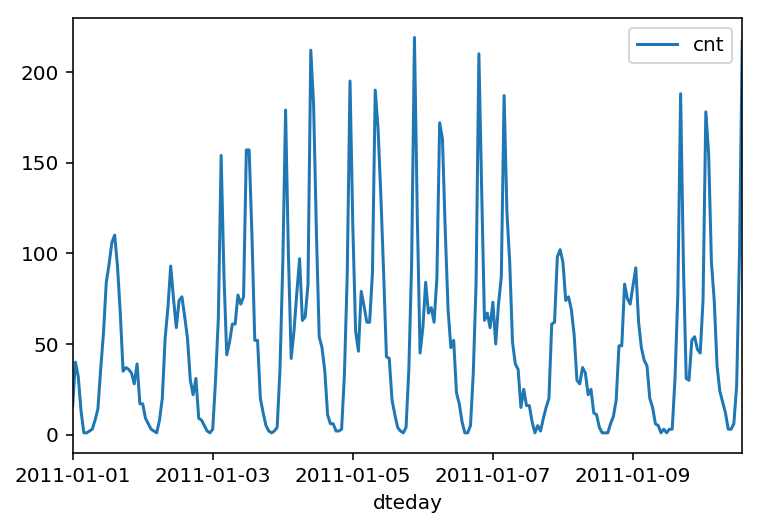

In [6]:
rides[:24*10].plot(x='dteday', y='cnt')

### 处理哑变量 Process Dummies

+ More details about the dataset https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
+ More details about the process  [Pandas 处理 dummy variable](http://blog.csdn.net/weiwei9363/article/details/78255210)

In [7]:
dummies_fields = ['season', 'hr', 'mnth', 'weekday', 'weathersit']

for each in dummies_fields:
    dummies = pd.get_dummies( rides.loc[:, each], prefix=each )
    rides = pd.concat( [rides, dummies], axis=1 )
    
drop_fields = [ 'season', 'hr', 'mnth', 'weekday', 'weathersit', 'instant', 'dteday', 'atemp' ]
data = rides.drop(drop_fields, axis=1)
data.head()



,yr,holiday,workingday,temp,hum,windspeed,casual,registered,cnt,season_1,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,0,0,0,0.24,0.81,0.0,3,13,16,1,...,0,0,0,0,0,1,1,0,0,0
1,0,0,0,0.22,0.80,0.0,8,32,40,1,...,0,0,0,0,0,1,1,0,0,0
2,0,0,0,0.22,0.80,0.0,5,27,32,1,...,0,0,0,0,0,1,1,0,0,0
3,0,0,0,0.24,0.75,0.0,3,10,13,1,...,0,0,0,0,0,1,1,0,0,0
4,0,0,0,0.24,0.75,0.0,0,1,1,1,...,0,0,0,0,0,1,1,0,0,0


### 标准化数据 Standardizing

+ 将mean, std保存，以便后来数据的恢复

In [8]:
standard_field = ['temp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
scaled_feature = {}
for each in standard_field:
    mean, std = data[each].mean(), data[each].std()
    scaled_feature[each] = [mean, std]
    data.loc[:, each] = (data.loc[:,each] - mean) / std
    
data.head()

,yr,holiday,workingday,temp,hum,windspeed,casual,registered,cnt,season_1,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,...,0,0,0,0,0,1,1,0,0,0
1,0,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,...,0,0,0,0,0,1,1,0,0,0
2,0,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,...,0,0,0,0,0,1,1,0,0,0
3,0,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,...,0,0,0,0,0,1,1,0,0,0
4,0,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,1,...,0,0,0,0,0,1,1,0,0,0


### 分割数据 Spliting the data

In [9]:
# Save data for approximately 21 days
test_data = data[-21*24:]

# Drop the test data
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']

features = data.drop( target_fields, axis=1 )
targets = data.loc[:, target_fields]

test_features = test_data.drop( target_fields, axis=1 )
test_targets = test_data.loc[:, target_fields]

In [10]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Step 2 建立神经网络 Building the network

+ Only one hidden layer
+ The activation function between input to hidden is sigmoid function $f(x) = 1/(1 + e^{-x})$
+ The activation function between hiiden to output is $f(x) = x$

In [11]:
class NeuralNetwork(object):
    def __init__( self, input_nodes, hidden_nodes, output_nodes, learning_rate ):
        # Set the number of nodes in input, hidden and output layers
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        
        # Set the learning rate
        self.lr = learning_rate
        
        # Initialize weights
        self.weights_input_to_hidden = np.random.normal( 0.0, self.input_nodes**-0.5, (self.input_nodes, self.hidden_nodes) )
        self.weights_hidden_to_output = np.random.normal( 0.0, self.hidden_nodes**-0.5, (self.hidden_nodes, self.output_nodes) )
        
        # Activation function
        self.activation_function = lambda x : 1 / ( 1 + np.exp(-x) )
        
    def train(self, features, targets):
        '''
        Arguments
        ---------
        
        features: 2D array, each row is one data record, each column is a feature
        targets: 1D array of target values
        
        '''
        
        n_record = features.shape[0]
        delta_weights_i_h = np.zeros( self.weights_input_to_hidden.shape )
        delta_weights_h_o = np.zeros( self.weights_hidden_to_output.shape )
        
        for X, y in zip( features, targets ):
            hidden_inputs = np.dot( X, self.weights_input_to_hidden )
            hidden_outputs = self.activation_function( hidden_inputs )
        
            final_inputs = np.dot( hidden_outputs, self.weights_hidden_to_output )
            final_outputs = final_inputs
            
            error = y - final_outputs
            
            output_error_term = error # error * 1
            
            hidden_error = np.dot( self.weights_hidden_to_output, output_error_term )
            
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs) # f'(hidden_input)
            
            # Weight step
            delta_weights_i_h += hidden_error_term * X[:,None]
            
            
            delta_weights_h_o += output_error_term * hidden_outputs[:,None]
            
        # Update the weights
        self.weights_input_to_hidden += self.lr * delta_weights_i_h/n_record
        self.weights_hidden_to_output += self.lr * delta_weights_h_o/n_record
            
    
    def run(self, features):
        hidden_inputs = np.dot( features, self.weights_input_to_hidden )
        hidden_output = self.activation_function( hidden_inputs )
        
        final_inputs = np.dot( hidden_output, self.weights_hidden_to_output )
        final_outputs = final_inputs
        
        return final_outputs

In [12]:
def MSE(y, Y):
    return np.mean( (y - Y)**2 )

## Step 3  单元测试 Unit tests

In [14]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
 
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
       # print(network.weights_input_to_hidden)
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.016s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Step 4 训练网络 Trainning the network

+ Choose the number of iterations
+ Choose the learning rate
+ Choose the number of hidden nodes

In [47]:
import sys

### Set the hyperparameters here ###
iterations = 2000
learning_rate = 0.8
hidden_nodes = 12
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.073 ... Validation loss: 0.154

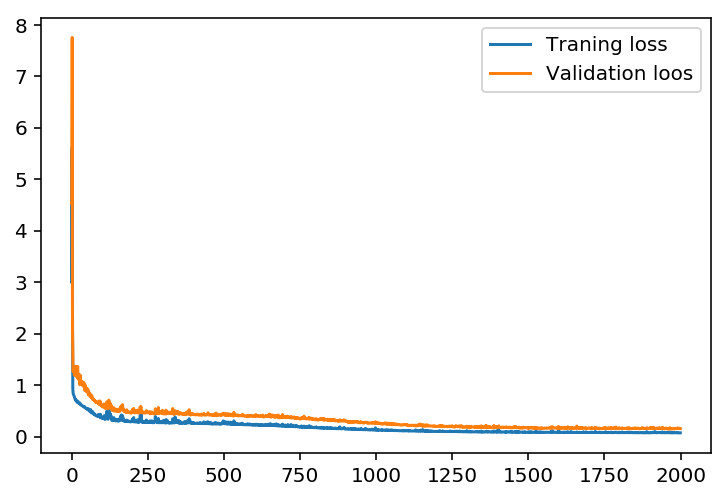

In [48]:
plt.plot(losses['train'], label='Traning loss')
plt.plot(losses['validation'], label='Validation loos')
plt.legend()

# Check out your predication

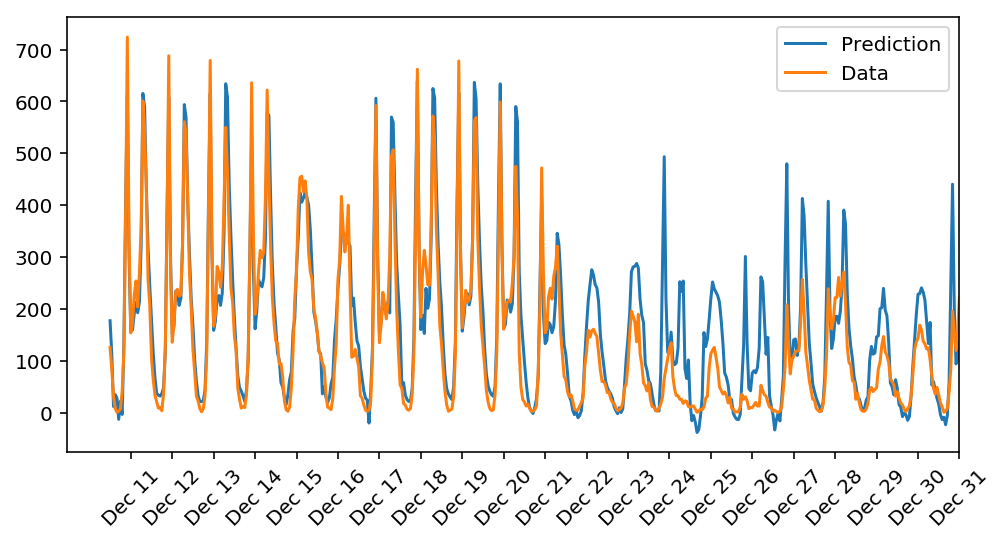

In [49]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_feature['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)